In [103]:
#!pip install httpx
import httpx
from PIL import Image
from io import BytesIO
import json
import pandas as pd
from dataclasses import dataclass
from IPython.display import Audio, display

In [4]:
# XC API endpoing (see https://xeno-canto.org/explore/api and https://xeno-canto.org/help/search)
API_URL = 'https://xeno-canto.org/api/2/recordings'

query = {
    'area': 'europe',
    'grp': '1', #birds
    'cnt': 'germany',
    'loc': 'bavaria',
    #box:LAT_MIN,LON_MIN,LAT_MAX,LON_MAX,
    #lic: '',       #license,
    #'q':">C",      #quality
    #'len': '10-15', #length (s)
    #'smp': ''       # sampling rate
    #'since': ''     # upload date
}

# Set query and params
query = ' '.join([f'{k}:{v}' for k, v in query.items()])
params = {'query': query, 'page': '1'}
print('Query: ', query)

# Request
response = httpx.get(API_URL, params=params).raise_for_status().json()

# Create the Response object (store 'recordings' as Pandas DataFrame with index: 'id')
@dataclass
class Response:
    numRecordings: int
    numSpecies: int
    page: int
    numPages: int
    recordings: pd.DataFrame

    def __str__(self):
      return f"(Page {self.page}/{self.numPages}) numRecordings: {len(self.recordings)}, totalRecordings: {self.numRecordings}, numSpecies: {self.numSpecies}"

recordings_df = pd.json_normalize(response.pop('recordings'))
assert len(recordings_df) > 0, 'numRecordings == 0'
recordings_df = recordings_df.set_index('id')
response = Response(**response, recordings=recordings_df)

Query:  area:europe grp:1 cnt:germany loc:bavaria


In [60]:
print(response)
print(response.recordings.index)
print(response.recordings.columns)

(Page 1/4) numRecordings: 500, totalRecordings: 1992, numSpecies: 147
Index(['772871', '302123', '688699', '361150', '305708', '289961', '342507',
       '790003', '817071', '699960',
       ...
       '288650', '282775', '281958', '279510', '214923', '214922', '214921',
       '214920', '211826', '211819'],
      dtype='object', name='id', length=500)
Index(['gen', 'sp', 'ssp', 'group', 'en', 'rec', 'cnt', 'loc', 'lat', 'lng',
       'alt', 'type', 'sex', 'stage', 'method', 'url', 'file', 'file-name',
       'lic', 'q', 'length', 'time', 'date', 'uploaded', 'also', 'rmk',
       'bird-seen', 'animal-seen', 'playback-used', 'temp', 'regnr', 'auto',
       'dvc', 'mic', 'smp', 'sono.small', 'sono.med', 'sono.large',
       'sono.full', 'osci.small', 'osci.med', 'osci.large'],
      dtype='object')


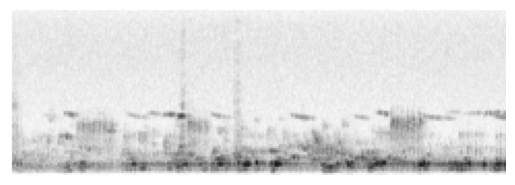

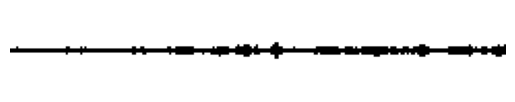

In [121]:
def plot_image(image):
  plt.imshow(image)
  plt.axis('off')
  plt.show()


def get_field(recordings: pd.DataFrame, id: str, field:str, prefix=True):
  url = recordings.loc[id][field]
  url = f"https:{url}" if prefix else url
  return httpx.get(url).raise_for_status()

def plot_sono(recordings: pd.DataFrame, id: str, version:str="small"):
  field = 'sono.'+ version
  response = get_field(recordings, id, field)
  plot_image(Image.open(BytesIO(response.content)))

def plot_osci(recordings: pd.DataFrame, id: str, version:str="small"):
  field = 'osci.'+ version
  response = get_field(recordings, id, field)
  plot_image(Image.open(BytesIO(response.content)))

id = '772871'
plot_sono(response.recordings, id)
plot_osci(response.recordings, id)

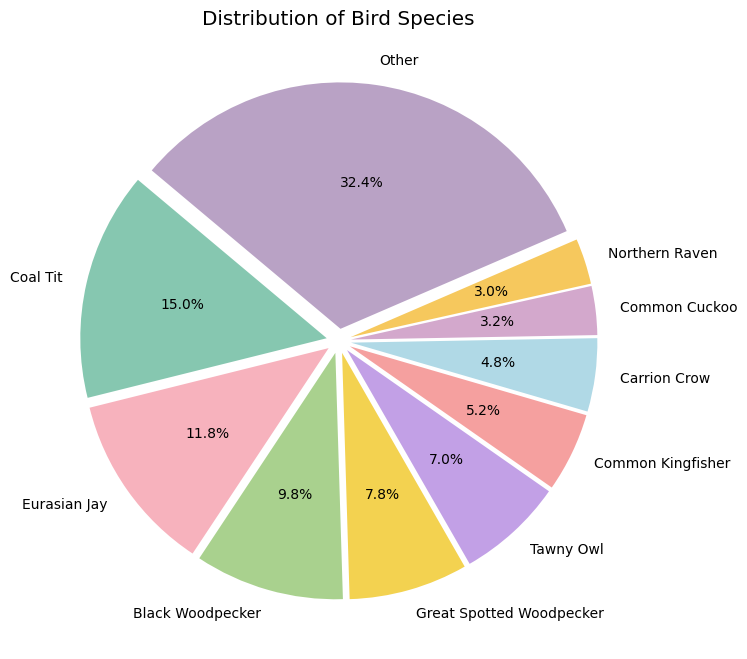

In [124]:
import matplotlib.pyplot as plt
df = response.recordings

threshold = 3

# Count the frequency of each bird species
species_counts = df['en'].value_counts()

# Calculate the total number of bird observations
total_bird_observations = len(df)

# Calculate the percentage of each species based on total bird observations
species_percentages = species_counts / total_bird_observations * 100

# Filter species that have at least treshold representation
top_species = species_percentages[species_percentages >= threshold]

# Create a new series with "Other" category for species below the threshold
other_species_count = species_percentages[species_percentages < threshold].sum()
top_species['Other'] = other_species_count

# Create the pie chart
plt.figure(figsize=(8, 8))
colors = ['#86c7b0', '#f7b2bd', '#a9d18e', '#f3d250', '#c2a0e6', '#f5a09f', '#b0d9e6', '#d3a8cc', '#f6c85d', '#b9a2c5']
plt.pie(top_species, labels=top_species.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=[0.05]*len(top_species))
plt.title('Distribution of Bird Species')
plt.show()

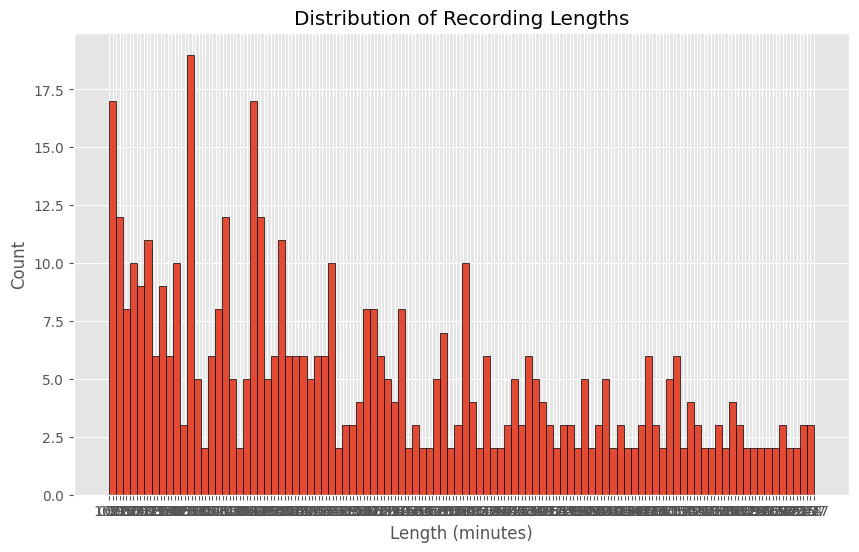

In [125]:
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=100, edgecolor='k')
plt.title('Distribution of Recording Lengths')
plt.xlabel('Length (minutes)')
plt.ylabel('Count')
plt.show()